# Laboratorium 4

### Konfiguracja

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import copy as cp

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [110]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


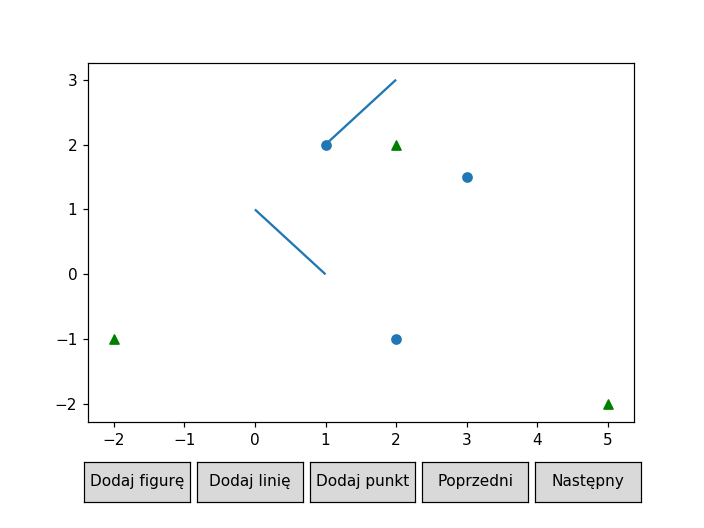

In [111]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


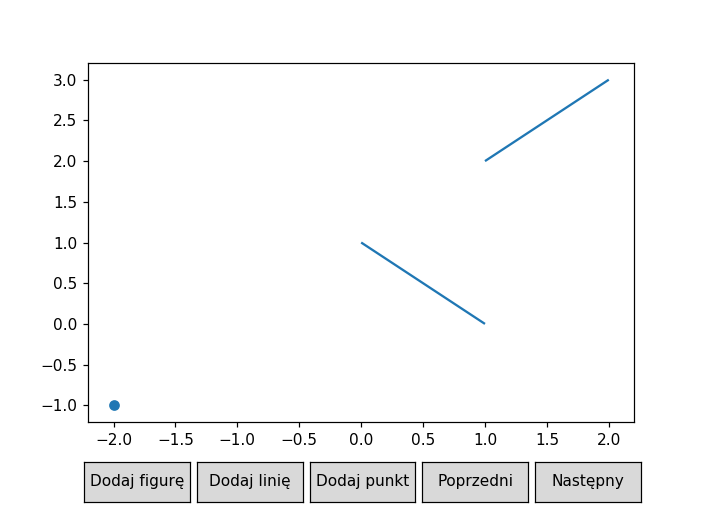

In [112]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


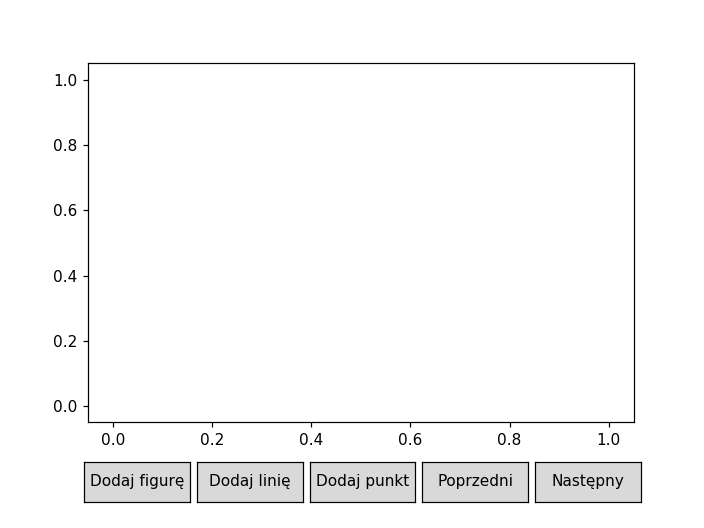

In [113]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


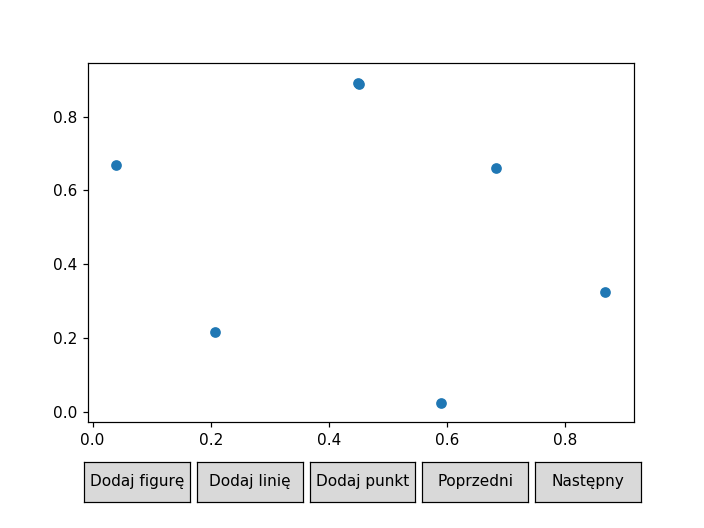

In [5]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

<IPython.core.display.Javascript object>


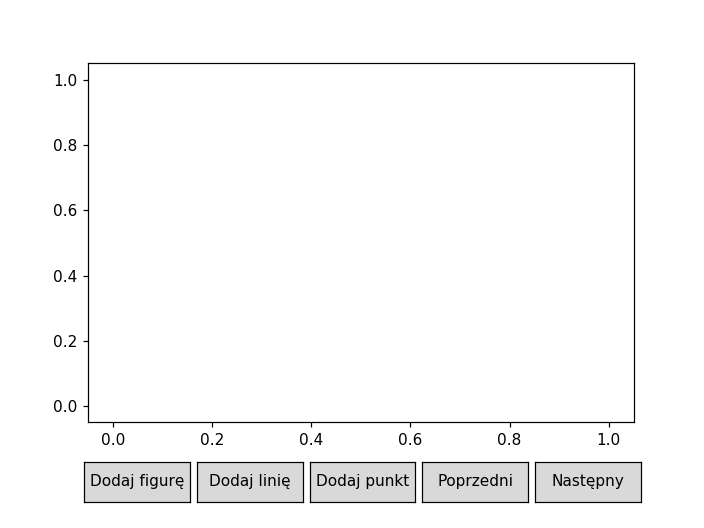

In [114]:
%matplotlib notebook
#Dodaj tu punkty, figury i/lub odcinki!
plotTemp = Plot()
plotTemp.draw()


<IPython.core.display.Javascript object>


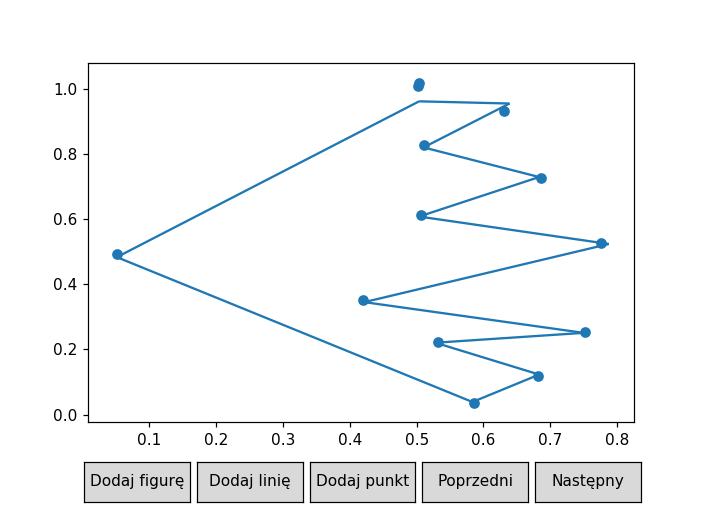

In [133]:
%matplotlib notebook
plot2 = Plot([plotTemp.get_added_elements()])
with open('myfile.json', 'w') as p:
    p.write(plot2.toJson())
    
plot2.draw()


In [115]:
%matplotlib notebook
def det(a,b,c):
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - a[1]*b[0] - a[0]*c[1]
def orientationToLine(A,B,C, eps=10**-6): # - right turn, + left turn
    orientation = det(A, B, C)
    if orientation < -eps:
        return -1
    elif orientation > eps:
        return 1
    else:
        return 0

In [116]:
with open('myfile.json') as p:
    points = Plot(json=p.read()).scenes[0].points[0].points
del(points[len(points)-1])
print(points)

IndexError: list index out of range

In [117]:
def yMonotonic(points):
    flag=False
    for i in range(len(points)):
        if(flag or points[i][1]<points[(i+1)%len(points)][1]):
            flag=True
            if(points[i][1]>points[(i+1)%len(points)][1]):
                return False
    return True
    

In [118]:
# print(points)
yMonotonic(points)

True

In [119]:
def gethalfs(points):
    top=[]
    bottom=[]
    mn=0
    mx=0
    for i in range(len(points)):
        if(points[i][0]>points[mx][0]): mx=i
        if(points[i][0]<points[mn][0]): mn=i
    for i in range(mn,mx+1):
        bottom.append(points[i])
    for i in range(mx,len(points)):
        top.append(points[i])
    for i in range(mn+1):
        top.append(points[i])
    return top, bottom
def colorPoints(points, clr=False):
    def prev(i): return(points[(i-1)%len(points)])
    def nxt(i): return(points[(i+1)%len(points)])
    colors=[]
    for i in range(len(points)):
        q=prev(i)
        e=nxt(i)
        a=orientationToLine(q,points[i],e) #- then right turn
        dy1, dy2=points[i][1] - q[1], e[1]-points[i][1] 
        if(dy1*dy2>0): colors.append('green') #Prawidłowy
        elif(dy1>0 and dy2<0 and a==-1): colors.append('blue') #Łączący
        elif(dy1<0 and dy2>0 and a==-1): colors.append('cyan') #Dzielący
        elif(dy1>0 and dy2<0 and a==1): colors.append('brown') #Górny
        elif(dy1<0 and dy2>0 and a==1): colors.append('red') #Dolny
        else: colors.append('green') #Prawidłowy gdy det==0
    lines=[]
    if(clr):
        print("Zielony : Prawidłowy")
        print("Niebieski : Dzielący")
        print("Jasno niebieski : Łączący")
        print("Brązowy : Początkowy")
        print("Czerwony : Końcowy")
    for i in range(len(points)):
        lines.append([points[i],nxt(i)])
    scenes=[Scene([PointsCollection([points[i]], color=colors[i]) for i in range(len(points))],[LinesCollection(lines,color='yellow')])]
    return scenes

Zielony : Prawidłowy
Niebieski : Dzielący
Jasno niebieski : Łączący
Brązowy : Początkowy
Czerwony : Końcowy


<IPython.core.display.Javascript object>


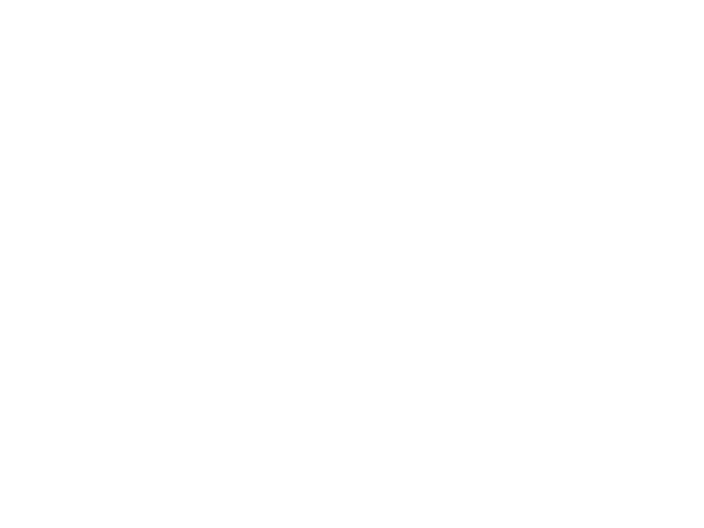

In [120]:
scenes=colorPoints(points, True)
plot3=Plot(scenes)
plot3.draw()

In [121]:
def triangle(points):
    if (not yMonotonic):
        print("ERROR _ Not y monotonic input")
        return False
    
    flag = False
    side = []
    side.append(0)
    points2 = cp.deepcopy(points)
    
    
    def keyY(point):
        return (-point[1])
    
    def prev(i): return (points2[(i - 1) % len(points2)])
    
    
    def nxt(i): return (points2[(i + 1) % len(points2)])
    
    points2[0].append(0)
    
    for i in range(1, len(points2)):
        if ((not flag) and points2[i][1] < nxt(i)[1]):
            flag = True
            points2[i].append(0)
#             side.append(0)
        elif (flag):
            points2[i].append(-1)
#             side.append(-1)
        else:
            points2[i].append(1)
#             side.append(1)
    
    points2 = sorted(points2, key=keyY)
    
    
    s = []  # s.append(x), s.pop(), s.empty()
    lines = []
    s.append(points2[0])
    s.append(points2[1])
    
    for i in range(2, len(points2)):
        a = s.pop()
        b = s.pop()
        current = points2[i]
        if (not current[2] == a[2]) and (not current[2] == 0):  # 1
            lines.append([[current[0], current[1]], [a[0], a[1]]])
            if not b[2] == 0: lines.append([[current[0], current[1]], [b[0], b[1]]])
            while s : #While stack is not empty
                c = s.pop()
                if not c[2] == 0: lines.append([[current[0], current[1]], [c[0], c[1]]])
            s.append(a)
            s.append(current)
        elif current[2] == a[2] or current[2] == 0: #2
            if a[2] == 1: #2,left
                flag= orientationToLine([b[0],b[1]], [a[0],a[1]], [current[0],current[1]])>0
                while orientationToLine([b[0],b[1]], [a[0],a[1]], [current[0],current[1]]) > 0:
                    lines.append([[current[0], current[1]], [b[0], b[1]]])
                    a=b
                    if s : b=s.pop()
                    else:
                        break
                if s or not flag : s.append(b)
                s.append(a)
                s.append(current)
            if a[2] == -1: #2,right
                flag=orientationToLine([b[0],b[1]], [a[0],a[1]], [current[0],current[1]])<0
                while orientationToLine(b, a, current) < 0:
                    lines.append([[current[0], current[1]], [b[0], b[1]]])
                    a=b
                    if s : b=s.pop()
                    else:
                        break
                if s or not flag: s.append(b)
                s.append(a)
                s.append(current) 
    return lines


<IPython.core.display.Javascript object>


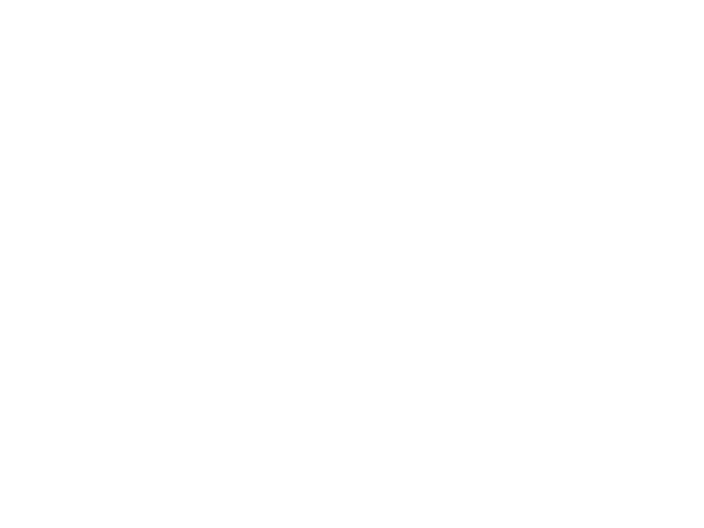

In [122]:
lines2=[]
def nxt(i,points): return(points[(i+1)%len(points)])
for i in range(len(points)):
    lines2.append([points[i],nxt(i,points)])
t =triangle(points)
scenes=[Scene([PointsCollection(points)],[LinesCollection(t, color='red'),LinesCollection(lines2,color='yellow')])]
plot8 = Plot(scenes)
plot8.draw()

In [123]:
def triangleStep(points):
    if (not yMonotonic):
        print("ERROR _ Not y monotonic input")
        return False
    lines2=[]
    def nxt(i): return(points[(i+1)%len(points)])
    for i in range(len(points)):
        lines2.append([points[i],nxt(i)])
    flag = False
    side = []
    side.append(0)
    points2 = cp.deepcopy(points)
    scenes=[]
#     scenes.append([Scene([PointsCollection(points,color='cyan')])])
    
    def addStep(lines,a,b,current):
        scenes.append(Scene([PointsCollection(points,color='yellow'),
                              PointsCollection([[a[0],a[1]],[b[0],b[1]]],color='brown'),
                              PointsCollection([[current[0],current[1]]],color='red')],
                             [LinesCollection(cp.deepcopy(lines),color='red'),LinesCollection(lines2,color='blue')]))
        
    
    def keyY(point):
        return (-point[1])
    
    def prev(i): return (points2[(i - 1) % len(points2)])
    
    
#     def nxt(i): return (points2[(i + 1) % len(points2)])
    
    points2[0].append(0)
    
    for i in range(1, len(points2)):
        if ((not flag) and points2[i][1] < nxt(i)[1]):
            flag = True
            points2[i].append(0)
#             side.append(0)
        elif (flag):
            points2[i].append(-1)
#             side.append(-1)
        else:
            points2[i].append(1)
#             side.append(1)
    
    points2 = sorted(points2, key=keyY)
    
    
    s = []  # s.append(x), s.pop(), s.empty()
    lines = []
    s.append(points2[0])
    s.append(points2[1])
    
    for i in range(2, len(points2)):
        a = s.pop()
        b = s.pop()
        current = points2[i]
        addStep(lines,a,b,current)
        if (not current[2] == a[2]) and (not current[2] == 0):  # 1
            lines.append([[current[0], current[1]], [a[0], a[1]]])
            addStep(lines,a,b,current)
            if not b[2] == 0: 
                lines.append([[current[0], current[1]], [b[0], b[1]]])
                addStep(lines,a,b,current)
            c=a
            while s and not c[2]==current[2] : #While stack is not empty
                c = s.pop()
#                 if not c[2] == 0: 
                lines.append([[current[0], current[1]], [c[0], c[1]]])
                addStep(lines,a,c,current)
            s=[]
            s.append(a)
            s.append(current)
        elif current[2] == a[2] or current[2] == 0: #2
            if a[2] == 1: #2,left
                flag= orientationToLine([b[0],b[1]], [a[0],a[1]], [current[0],current[1]]) > 0
                while orientationToLine([b[0],b[1]], [a[0],a[1]], [current[0],current[1]]) > 0:
                    addStep(lines,a,b,current)
                    lines.append([[current[0], current[1]], [b[0], b[1]]])
                    a=b
                    if s : b=s.pop()
                        
                    else:
                        break
                if s or not flag: s.append(b)
                s.append(a)
                s.append(current)
            if a[2] == -1: #2,right
                flag=orientationToLine([b[0],b[1]], [a[0],a[1]], [current[0],current[1]])<0
                while orientationToLine(b, a, current) < 0:
                    addStep(lines,a,b,current)
                    lines.append([[current[0], current[1]], [b[0], b[1]]])
                    a=b
                    if s : b=s.pop()
                    else:
                        break
                if s or not flag: s.append(b)
                s.append(a)
                s.append(current) 
        addStep(lines,a,b,current)
    return scenes


<IPython.core.display.Javascript object>


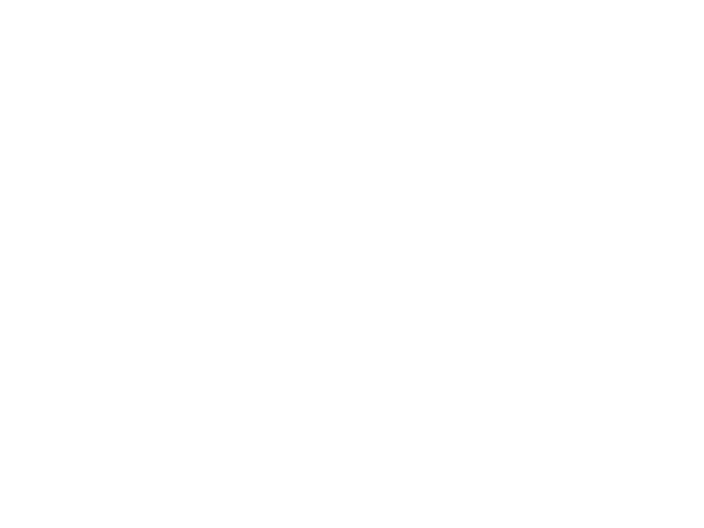

In [124]:
scenes=triangleStep(points)
plot9=Plot(scenes)
plot9.draw()

<IPython.core.display.Javascript object>


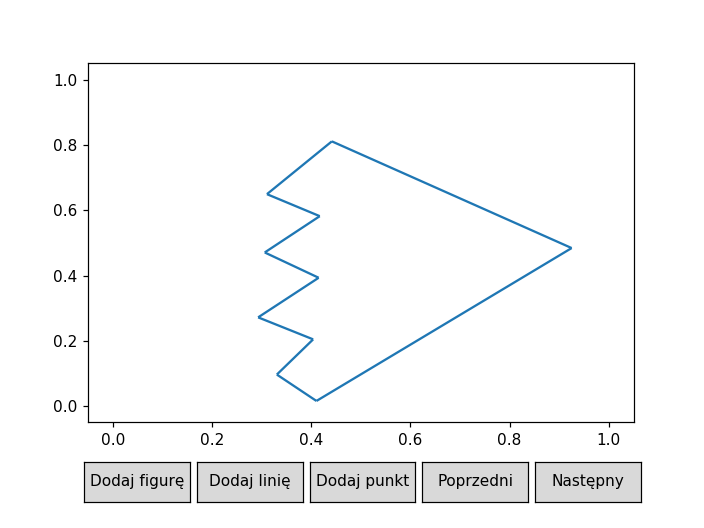

In [134]:
%matplotlib notebook
#Dodaj tu punkty, figury i/lub odcinki!
plotTemp = Plot()
plotTemp.draw()

<IPython.core.display.Javascript object>


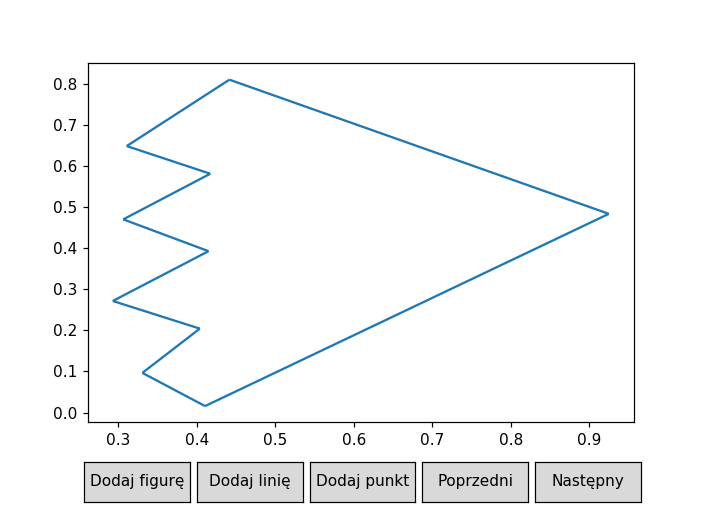

In [135]:
%matplotlib notebook
plot2 = Plot([plotTemp.get_added_elements()])
with open('myfile.json', 'w') as p:
    p.write(plot2.toJson())
    
plot2.draw()

In [136]:
with open('myfile.json') as p:
    lines = Plot(json=p.read()).scenes[0].lines[0].lines
# print(lines)
points=[]
for each in lines:
    points.append(each[0])
# print(points)

Zielony : Prawidłowy
Niebieski : Dzielący
Jasno niebieski : Łączący
Brązowy : Początkowy
Czerwony : Końcowy


<IPython.core.display.Javascript object>


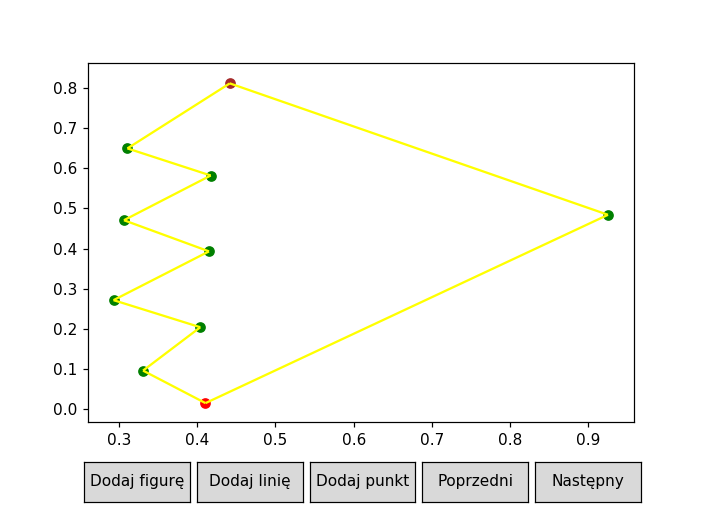

In [137]:
scenes=colorPoints(points, True)
plot3=Plot(scenes)
plot3.draw()


<IPython.core.display.Javascript object>


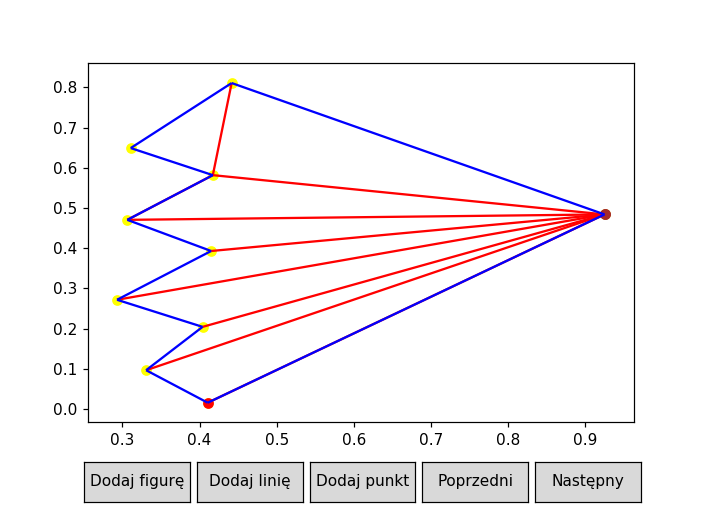

In [138]:
scenes=triangleStep(points)
plot9=Plot(scenes)
plot9.draw()